In [3]:
#İlaç Reçetesi Sınıflandırma Projesi'ne hoş geldiniz!
#Amacımız hastalarin sağlık verilerine göre reçete edilen ilacın türünü tahmin etmektir. 
#Veri kümesi özellikleri arasında Yaş, Cinsiyet, Kan Basıncı (BP), Kolesterol seviyeleri, Sodyum (Na) ve Potasyum (K) seviyeleri yer alır ve hedef değişkenimiz 'İlaç' türüdür.
# Aşağıdaki sınıflandırma algoritmalarını keşfedip uygulayacağız:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Dataset yukleme
data_path = 'Drug.csv'
data = pd.read_csv(data_path)

# Ilk birkac satirin alinip datasetin basarili bir sekilde alinmasinin teyit edilmesi
print(data.head())

   Age Sex      BP Cholesterol        Na         K   Drug
0   23   F    HIGH        HIGH  0.792535  0.031258  drugY
1   47   M     LOW        HIGH  0.739309  0.056468  drugC
2   47   M     LOW        HIGH  0.697269  0.068944  drugC
3   28   F  NORMAL        HIGH  0.563682  0.072289  drugX
4   61   F     LOW        HIGH  0.559294  0.030998  drugY


In [4]:
# 1. Data Exploration
# Bu kisimda kullandigimiz datasetin ozelliklerini inceleyecegiz ve degismesi gereken veri tipleri gibi onemli kisimlari inceleyecegiz.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na           200 non-null    float64
 5   K            200 non-null    float64
 6   Drug         200 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 11.1+ KB


In [5]:
data.describe()

,Age,Na,K
count,200.000000,200.000000,200.000000
mean,44.315000,0.697095,0.050174
std,16.544315,0.118907,0.017611
min,15.000000,0.500169,0.020022
25%,31.000000,0.583887,0.035054
50%,45.000000,0.721853,0.049663
75%,58.000000,0.801494,0.066000
max,74.000000,0.896056,0.079788


In [7]:
#eksik data belirleme

data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64

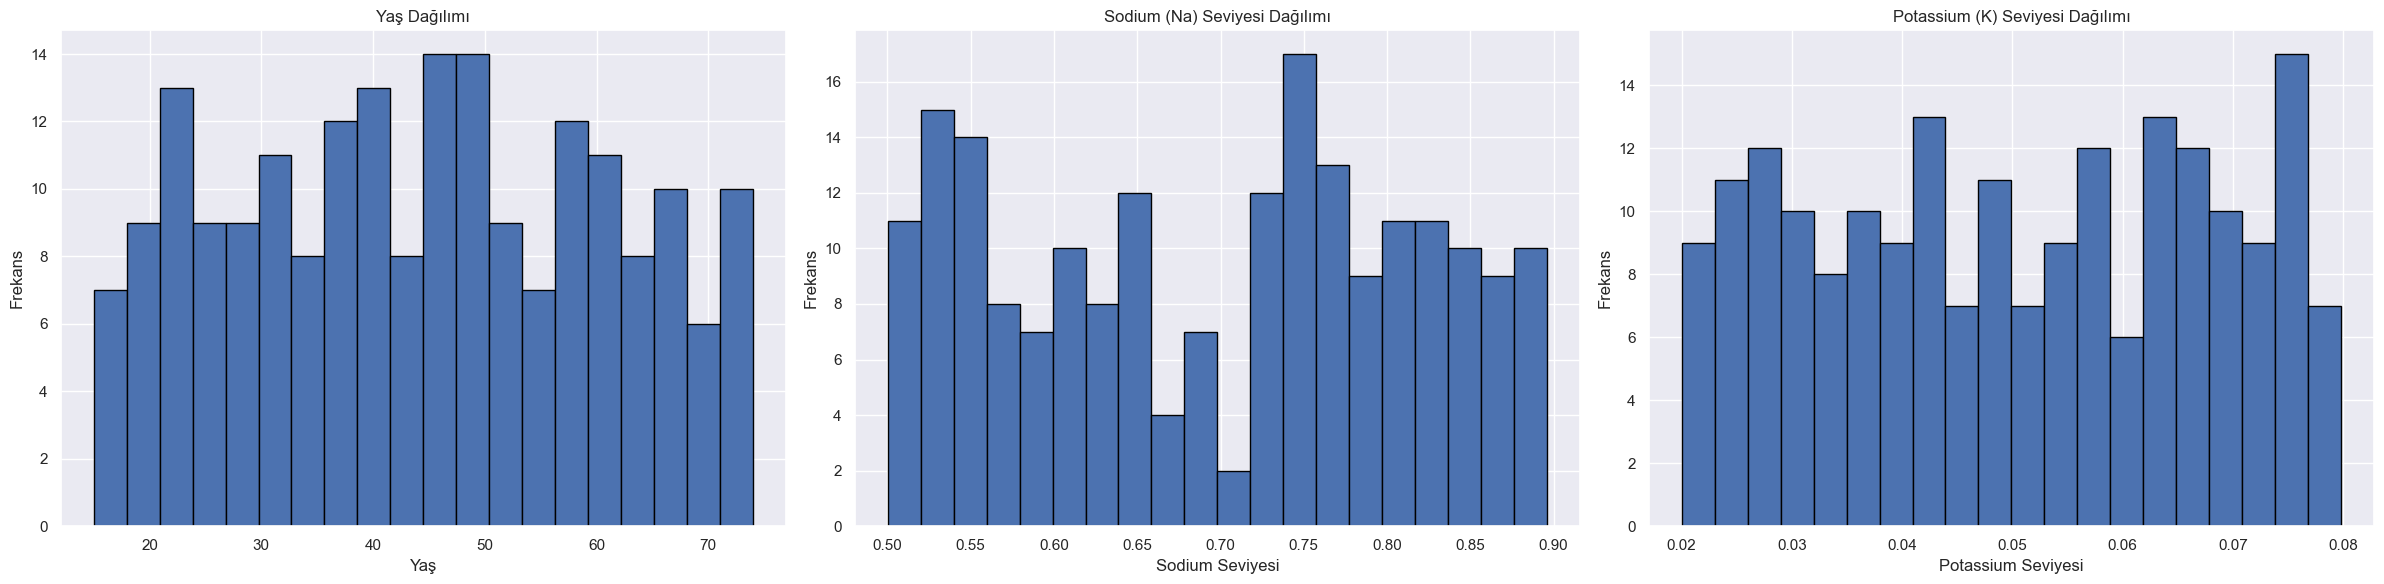

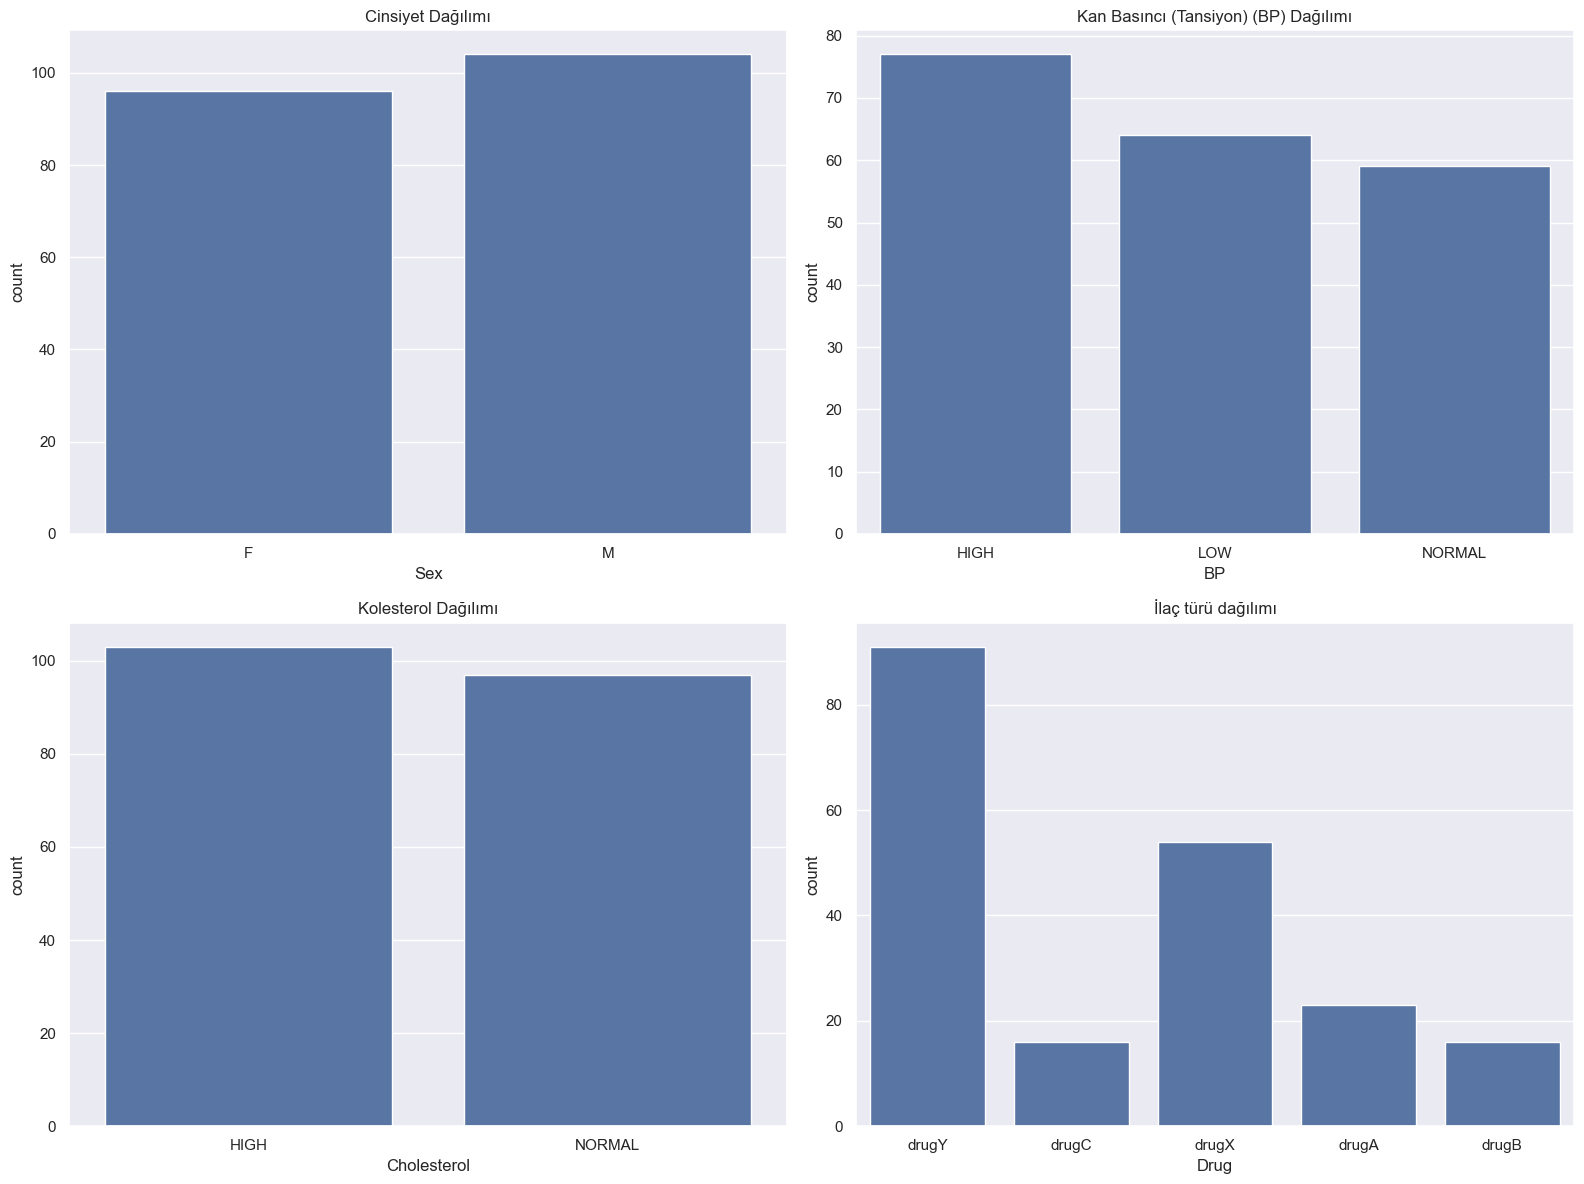

In [9]:
# Sayısal Özelliklerin Dağılımı
fig, ax = plt.subplots(1, 3, figsize=(24, 6))  # Adjust for 3 subplots
data['Age'].hist(ax=ax[0], bins=20, edgecolor='black')
ax[0].set_title('Yaş Dağılımı')
ax[0].set_xlabel('Yaş')
ax[0].set_ylabel('Frekans')

data['Na'].hist(ax=ax[1], bins=20, edgecolor='black')  # Plot for Sodium
ax[1].set_title('Sodium (Na) Seviyesi Dağılımı')
ax[1].set_xlabel('Sodium Seviyesi')
ax[1].set_ylabel('Frekans')

data['K'].hist(ax=ax[2], bins=20, edgecolor='black')  # Plot for Potassium
ax[2].set_title('Potassium (K) Seviyesi Dağılımı')
ax[2].set_xlabel('Potassium Seviyesi')
ax[2].set_ylabel('Frekans')

plt.tight_layout()


# Kategorik Özelliklerin Dağılımı
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.countplot(x='Sex', data=data, ax=ax[0, 0])
ax[0, 0].set_title('Cinsiyet Dağılımı')

sns.countplot(x='BP', data=data, ax=ax[0, 1])
ax[0, 1].set_title('Kan Basıncı (Tansiyon) (BP) Dağılımı')

sns.countplot(x='Cholesterol', data=data, ax=ax[1, 0])
ax[1, 0].set_title('Kolesterol Dağılımı')

sns.countplot(x='Drug', data=data, ax=ax[1, 1])
ax[1, 1].set_title('İlaç türü dağılımı')

plt.tight_layout()

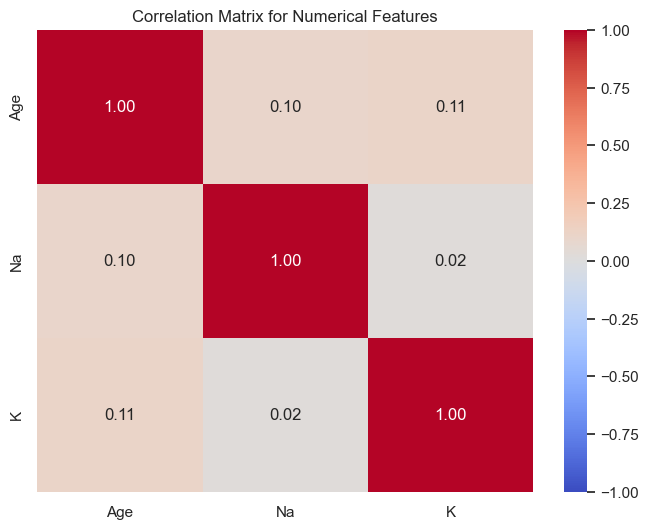

In [10]:
# Korelasyon Analizi
# Sayısal verilerin korelasyon analizi
numerical_data = data[['Age', 'Na', 'K']]
correlation_matrix = numerical_data.corr()

# Korelasyon matrisinin ısı haritası

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

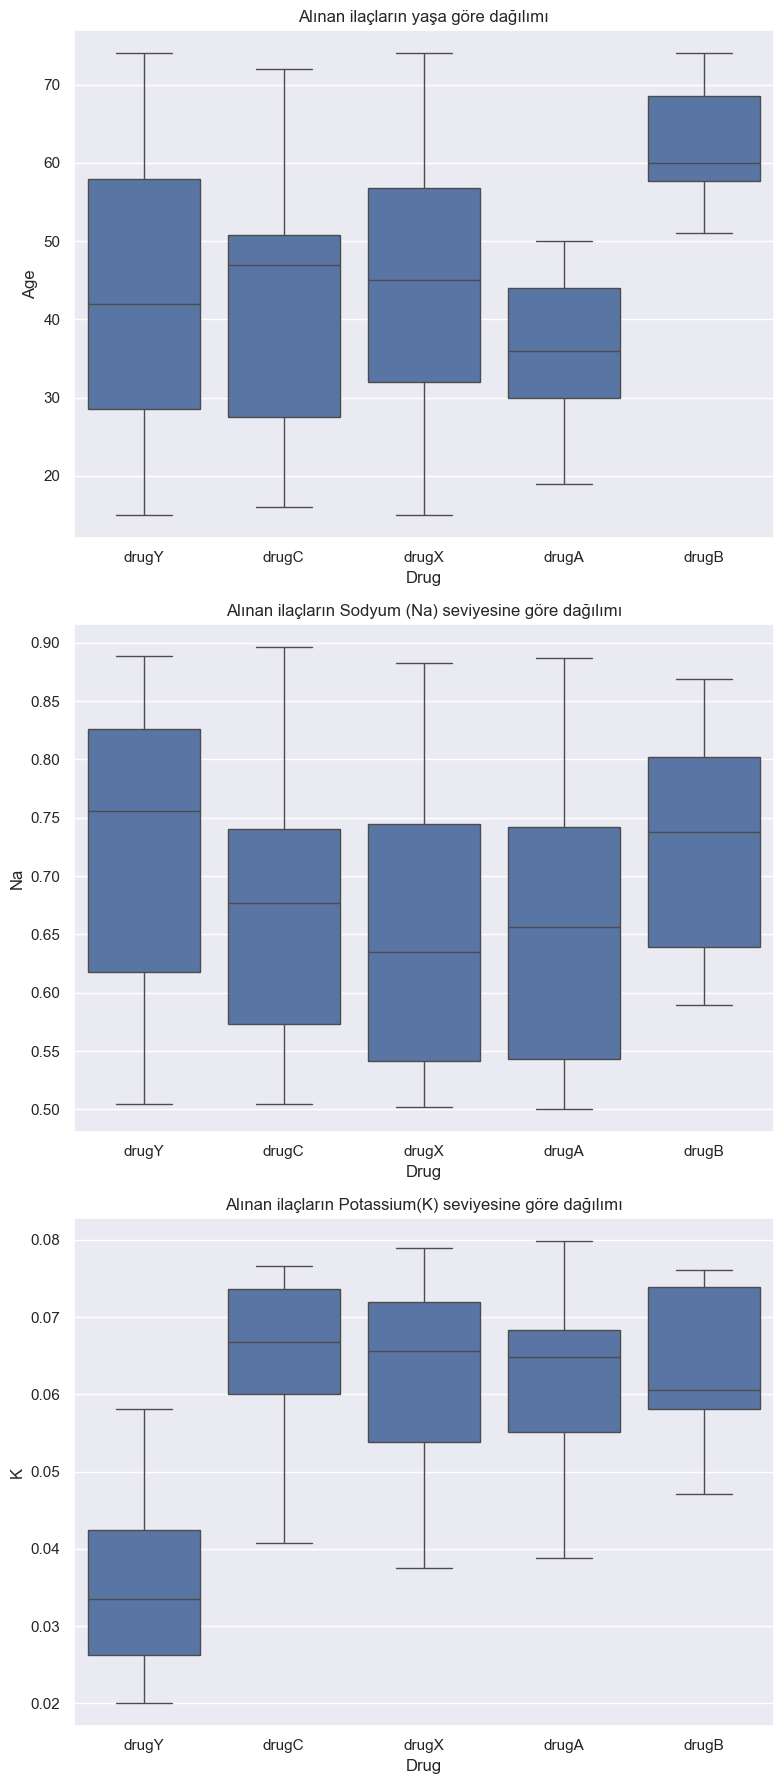

In [11]:
# 5. Özellik - Hedef Dağılımı Analizi
fig, ax = plt.subplots(3, 1, figsize=(8, 18))

# Boxplot for Age vs Drug
sns.boxplot(x='Drug', y='Age', data=data, ax=ax[0])
ax[0].set_title('Alınan ilaçların yaşa göre dağılımı')

# Boxplot for Na vs Drug
sns.boxplot(x='Drug', y='Na', data=data, ax=ax[1])
ax[1].set_title('Alınan ilaçların Sodyum (Na) seviyesine göre dağılımı')

# Boxplot for K vs Drug
sns.boxplot(x='Drug', y='K', data=data, ax=ax[2])
ax[2].set_title('Alınan ilaçların Potassium(K) seviyesine göre dağılımı')

plt.tight_layout()

In [12]:
# 2.Data Onisleme
# Bu önemli adımda veri setimizi modelleme aşamasına hazırlayarak verilerimizin makine öğrenmesi algoritmalarına uygun formatta olmasını sağlıyoruz.
# Veri ön işlemedeki ana görevler arasında kategorik değişkenlerin encode edilmesi, sayısal özelliklerin ölçeklendirilmesi ve verilerin eğitim ve test kümelerine bölünmesi yer alır.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = data.drop('Drug', axis=1)
y = data['Drug']

# Identifying numerical and categorical features
numerical_features = ['Age', 'Na', 'K']
categorical_features = ['Sex', 'BP', 'Cholesterol']

# Datayi test ve train olarak 2ye bolme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a column transformer with one-hot encoding for categorical features and scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fitting the transformer on the training data and transforming both the training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [14]:
# 3.Model Building 
# Bu aşamada, seçtiğimiz algoritmaları kullanarak dört farklı makine öğrenimi modeli oluşturup eğiteceğiz: 
# K-Nearest Neighbors (KNN)
# Lojistik Regresyon
# Karar Ağaçları 
# Destek Vektör Makineleri (SVM). 
# Her model, eğitim veri setimiz üzerinde eğitilecek ve ardından test veri seti üzerindeki performansına göre değerlendirilecektir.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the models
knn = KNeighborsClassifier()
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
decision_tree = DecisionTreeClassifier()
svm = SVC()

# Dictionary to store models and their respective accuracies
models = {
    'K-Nearest Neighbors': knn,
    'Logistic Regression': log_reg,
    'Decision Tree': decision_tree,
    'Support Vector Machine': svm
}

# Dictionary to store accuracies
accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_processed)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy

accuracies

{'K-Nearest Neighbors': 0.875,
 'Logistic Regression': 0.975,
 'Decision Tree': 0.875,
 'Support Vector Machine': 0.9}

In [16]:
# 4.Model Degerlendirme
# Modellerimizi eğittikten sonraki önemli adım, performanslarını değerlendirmek ve güçlü ve zayıf yönlerini anlamaktır.
# Her modelin etkinliğini değerlendirmek için öncelikle doğruluğu kullanırız, ancak hassasiyet, geri çağırma ve F1 puanı gibi diğer ölçümler, özellikle dengesiz veri kümeleri bağlamında ek bilgiler sağlar.

from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
# Initializing a dictionary to store evaluation metrics
model_evaluation_metrics = {}

# Iterating over each model to evaluate
for model_name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test_processed)
    
    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    classif_report = classification_report(y_test, y_pred)
    
    # Storing the results
    model_evaluation_metrics[model_name] = {
        'Confusion Matrix': conf_matrix,
        'Classification Report': classif_report
    }
    
    # Outputting the results for review
    print(f"{model_name} Evaluation Metrics:")
    print("Confusion Matrix:")
    print(tabulate(conf_matrix, headers=model.classes_, tablefmt='grid'))
    print("\nClassification Report:")
    print(classif_report)
    print("\n" + "="*60 + "\n")

K-Nearest Neighbors Evaluation Metrics:
Confusion Matrix:
+---------+---------+---------+---------+---------+
|   drugA |   drugB |   drugC |   drugX |   drugY |
+=========+=========+=========+=========+=========+
|       6 |       0 |       0 |       0 |       0 |
+---------+---------+---------+---------+---------+
|       0 |       3 |       0 |       0 |       0 |
+---------+---------+---------+---------+---------+
|       1 |       0 |       2 |       1 |       1 |
+---------+---------+---------+---------+---------+
|       1 |       0 |       0 |       9 |       1 |
+---------+---------+---------+---------+---------+
|       0 |       0 |       0 |       0 |      15 |
+---------+---------+---------+---------+---------+

Classification Report:
              precision    recall  f1-score   support

       drugA       0.75      1.00      0.86         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      0.40      0.57         5
       drugX       0.90  

Görselleştiriliyor: K-Nearest Neighbors


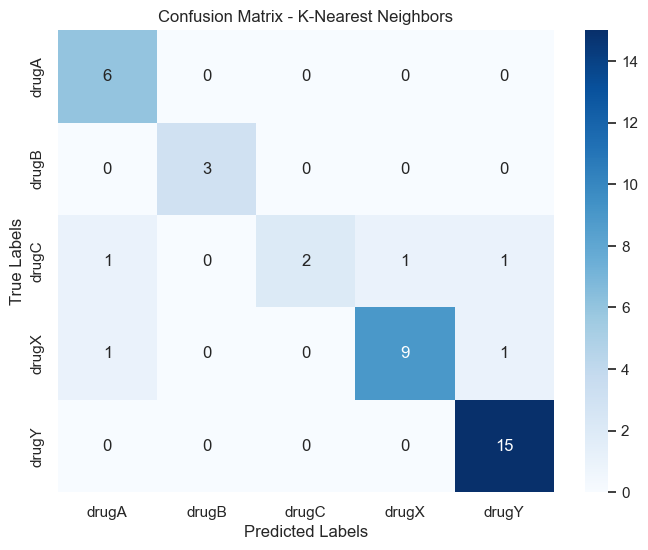

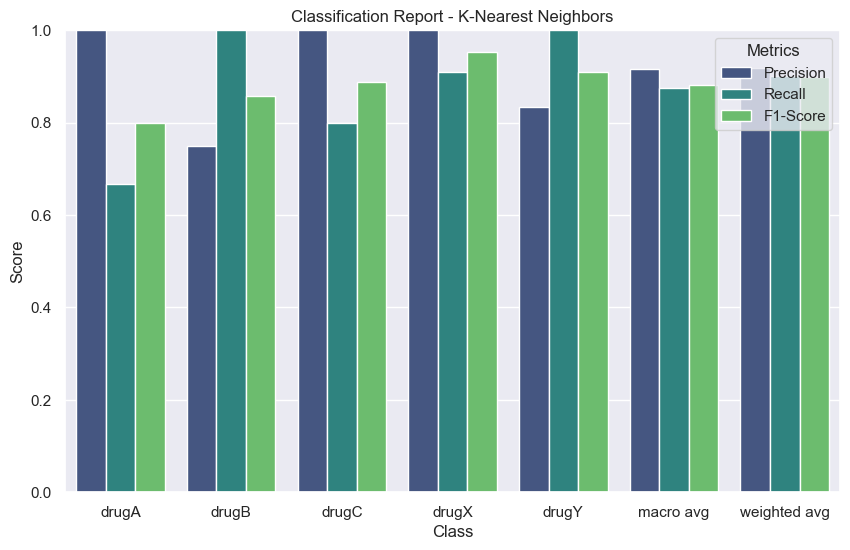

Görselleştiriliyor: Logistic Regression


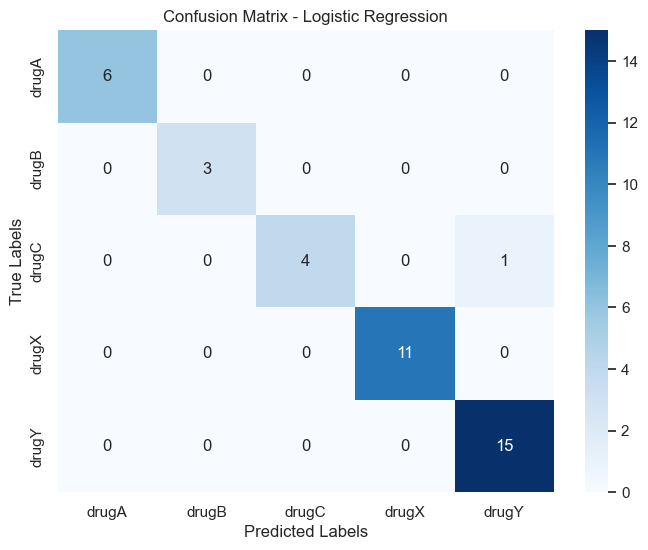

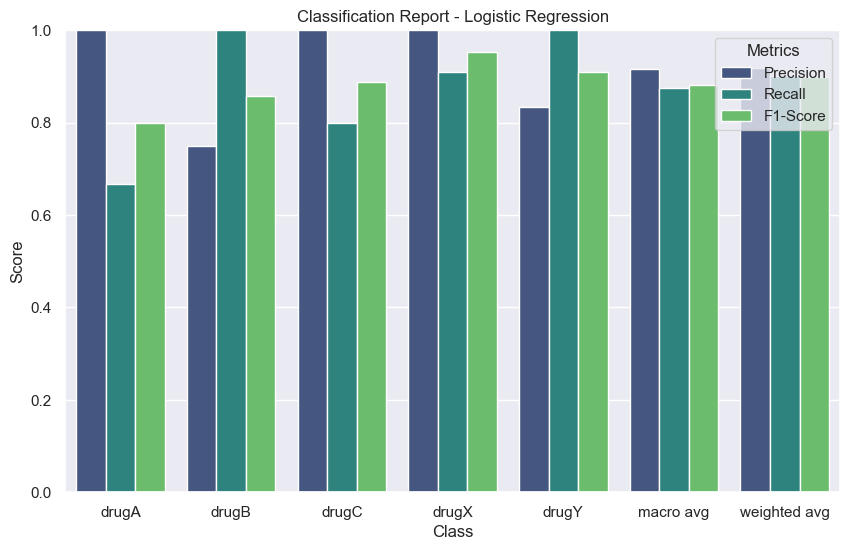

Görselleştiriliyor: Decision Tree


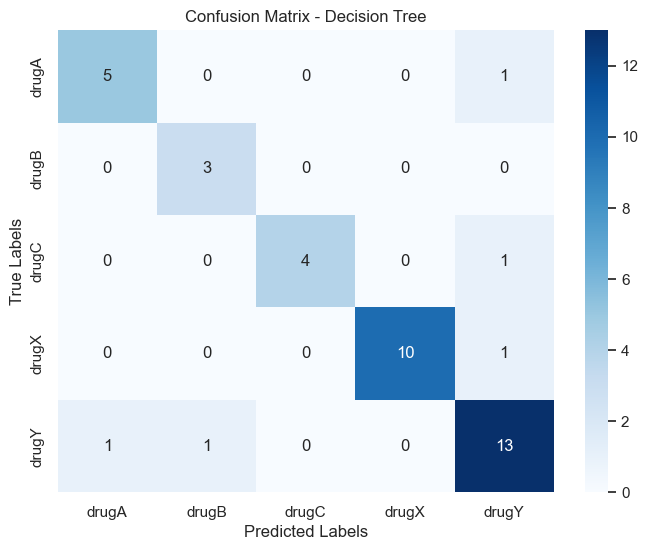

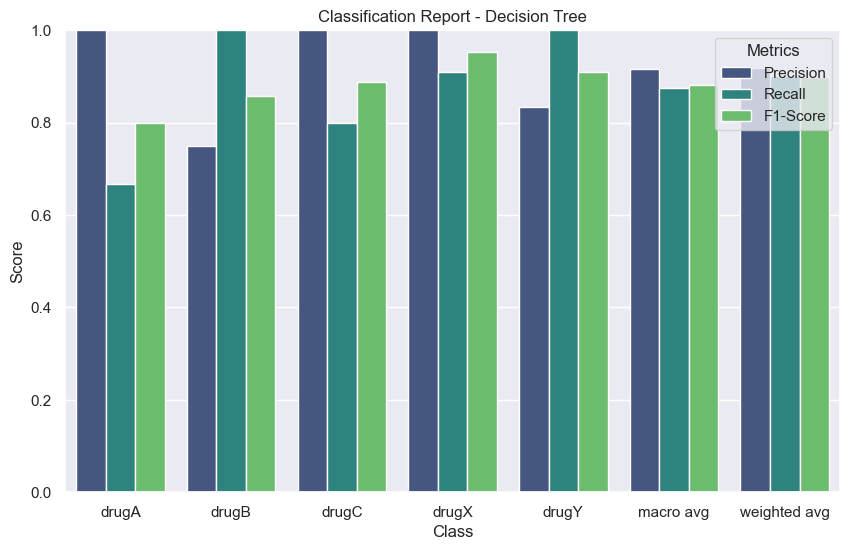

Görselleştiriliyor: Support Vector Machine


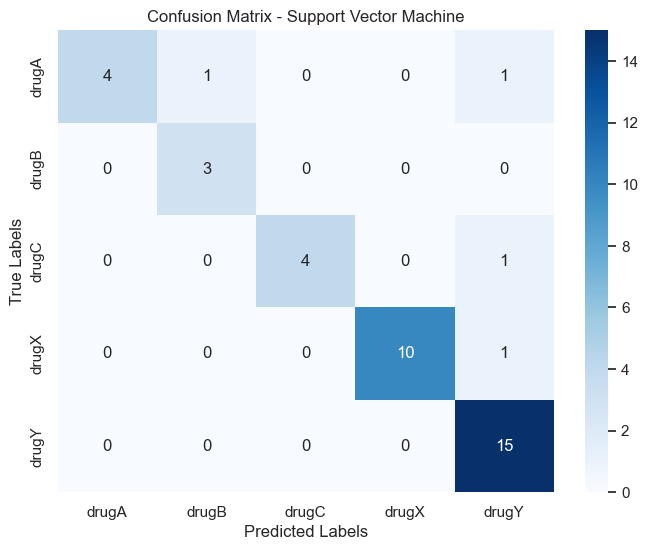

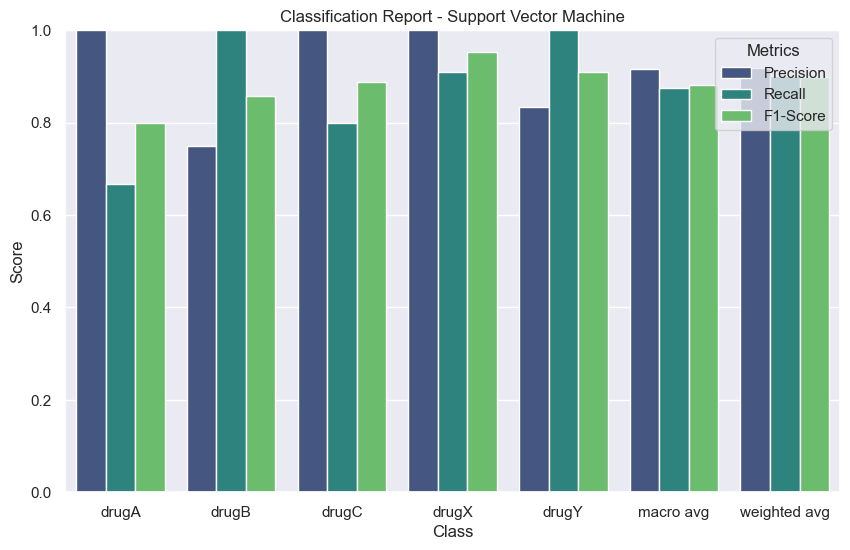

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

# Görselleştirme için bir fonksiyon
def visualize_evaluation_metrics(model_name, conf_matrix, classif_report, classes):
    # Confusion Matrix Görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Classification Report'un bir DataFrame'e dönüştürülmesi
    report_data = []
    for label, metrics in classification_report(y_test, y_pred, output_dict=True).items():
        if isinstance(metrics, dict):
            report_data.append([label, metrics["precision"], metrics["recall"], metrics["f1-score"], metrics["support"]])
    report_df = pd.DataFrame(report_data, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])

    # Classification Report Görselleştirme
    plt.figure(figsize=(10, 6))
    sns.barplot(data=report_df.melt(id_vars=["Class"], value_vars=["Precision", "Recall", "F1-Score"]),
                x="Class", y="value", hue="variable", palette="viridis")
    plt.title(f"Classification Report - {model_name}")
    plt.ylabel("Score")
    plt.xlabel("Class")
    plt.ylim(0, 1)
    plt.legend(loc="upper right", title="Metrics")
    plt.show()

# Her model için görselleştirme
for model_name, metrics in model_evaluation_metrics.items():
    conf_matrix = metrics['Confusion Matrix']
    classif_report = metrics['Classification Report']
    
    print(f"Görselleştiriliyor: {model_name}")
    visualize_evaluation_metrics(model_name, conf_matrix, classif_report, classes=model.classes_)


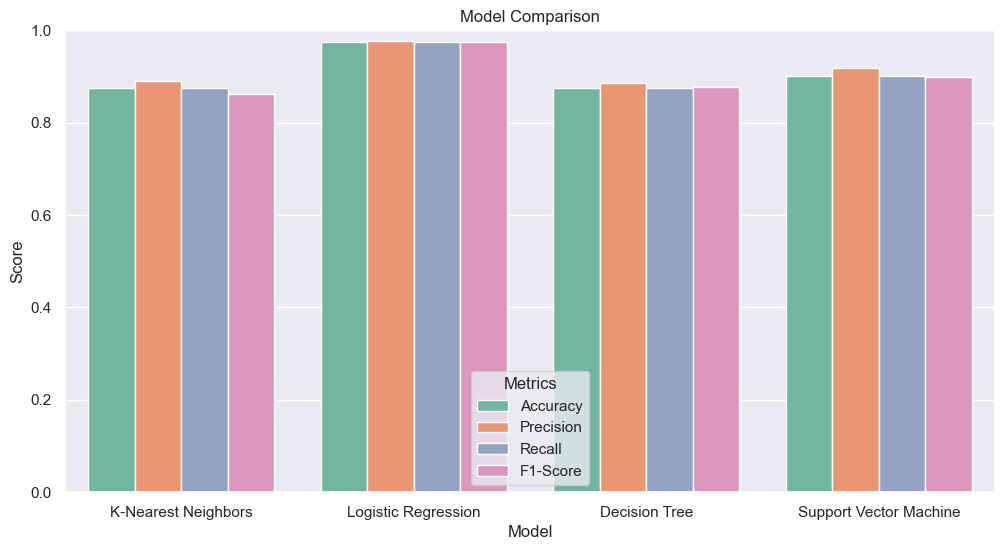

+------------------------+------------+-------------+----------+------------+
| Model                  |   Accuracy |   Precision |   Recall |   F1-Score |
+========================+============+=============+==========+============+
| K-Nearest Neighbors    |      0.875 |    0.890882 |    0.875 |   0.862277 |
+------------------------+------------+-------------+----------+------------+
| Logistic Regression    |      0.975 |    0.976562 |    0.975 |   0.974014 |
+------------------------+------------+-------------+----------+------------+
| Decision Tree          |      0.875 |    0.885938 |    0.875 |   0.876818 |
+------------------------+------------+-------------+----------+------------+
| Support Vector Machine |      0.9   |    0.91875  |    0.9   |   0.898211 |
+------------------------+------------+-------------+----------+------------+


In [ ]:

#Modellerin birbirleri ile "f1_score", "accuracy_score", "precision", "recall" gibi metrikler uzerinden kiyaslanmasi yapilir. 

from sklearn.metrics import accuracy_score

# Kıyaslama sonuçlarını saklamak için bir DataFrame oluşturulur
comparison_data = []

# Her modelin metriklerini hesaplama ve tabloya eklenir
for model_name, metrics in model_evaluation_metrics.items():
    y_pred = models[model_name].predict(X_test_processed)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Genel (ortalama) metrikleri alinir
    accuracy = accuracy_score(y_test, y_pred)
    precision = report_dict["weighted avg"]["precision"]
    recall = report_dict["weighted avg"]["recall"]
    f1_score = report_dict["weighted avg"]["f1-score"]
    
    # Verileri listeye ekleme
    comparison_data.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })

comparison_df = pd.DataFrame(comparison_data)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-Score"]),
            x="Model", y="value", hue="variable", palette="Set2")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.show()


print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))
